## Loading of Steinmetz data

Load necessary modules for DL

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
#%%
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display


/home/arjunv/miniconda3/envs/pyt2/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/arjunv/miniconda3/envs/pyt2/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


Set device to GPU or CPU

In [3]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


In [6]:
# Functions to Build MLP

class Net(nn.Module):
  """
  Simulate MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: int
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module(f"Linear_{i}", layer) # Append layer to the model with a name

      actv_layer = eval(f"nn.{actv}") # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # forward pass of MLP
    return logits


# @markdown `train_test_classification(net, criterion, optimizer, train_loader, test_loader, num_epochs=1, verbose=True, training_plot=False)`
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=True, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: Instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.to(device)
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
        Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
    print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc


# @markdown `shuffle_and_split_data(X, y, seed)`
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[1]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[:,shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:,:test_size]
  y_test = y[:test_size]
  X_train = X[:,test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

Load Data

In [7]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [8]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

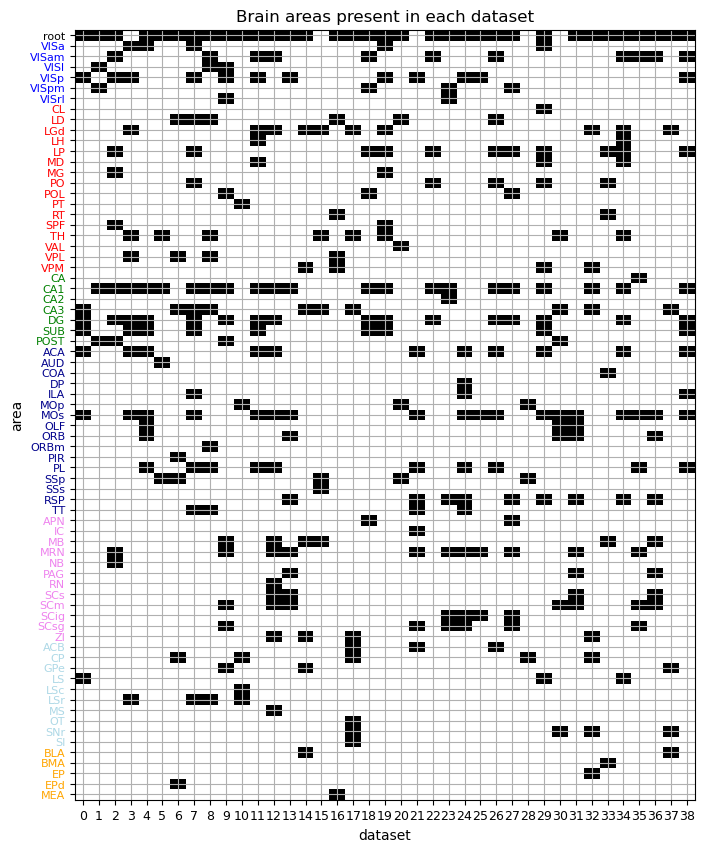

In [9]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])
['VISp' 'VISp' 'VISp' 'DG' 'VISp' 'VISp' 'SUB' 'DG' 'VISp' 'VISp' 'SUB'
 'DG' 'VISp' 'VISp' 'SUB' 'VISp' 'VISp' 'VISp' 'SUB' 'SUB' 'DG' 'VISp'
 'SUB' 'VISp' 'VISp' 'VISp' 'DG' 'VISp' 'SUB' 'SUB' 'SUB' 'SUB' 'SUB'
 'SUB' 'SUB' 'VISp' 'VISp' 'SUB' 'VISp' 'DG' 'SUB' 'VISp' 'DG' 'SUB' 'SUB'
 'LGd' 'SUB' 'VISp' 'VISp' 'SUB' 'SUB' 'VISp' 'SUB' 'SUB' 'DG' 'VISp'
 'SUB' 'DG' 'VISp' 'VISp' 'SUB' 'VISp' 'LGd' 'VISp' 'DG' 'SUB' 'SUB' 'DG'
 'SUB' 'DG' 'VISp' 'LGd' 'SUB' 'SUB' 'DG' 'SUB' 'SUB' 'SUB' 'DG' 'LGd'
 'SUB' 'SUB' 'SUB' 'SUB' 'SUB' 'SU

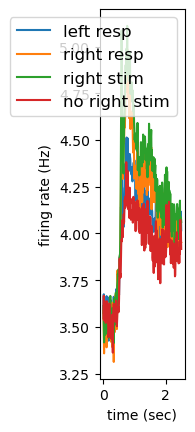

In [10]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

print(dat['brain_area'])
# dat = dat['brain_area'] == "VPM"
dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

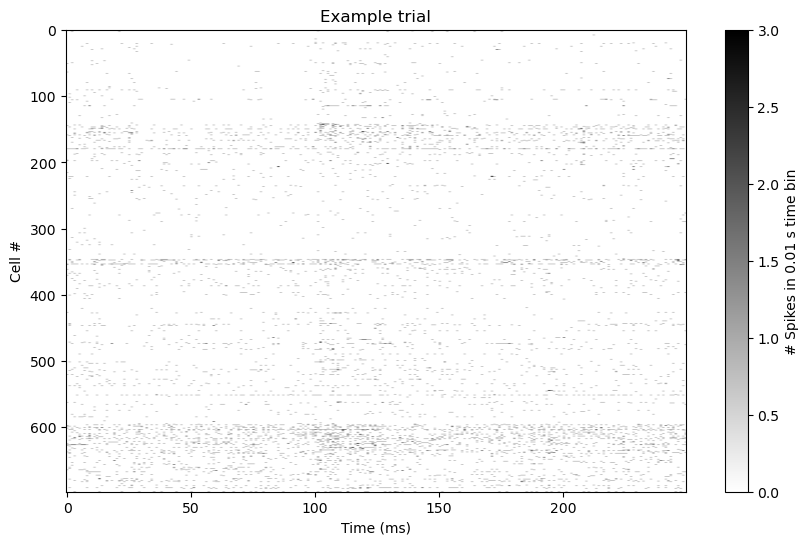

In [11]:
# Visulize the data from one trial
plt.figure(figsize = (10, 6))
plt.imshow(dat['spks'][:, 0, :], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

In [12]:
# Prepare data for MLP
X = torch.from_numpy(dat['spks']);
dat['response'][dat['response'] == -1] = 2 # targets can not be -1
y = torch.from_numpy(dat['response']); # responses is just one of multiple options for animals's behaivors,


# LSTM + MLP Model Building (Trial)

In [13]:
# Spike Data Shape
print(dat['spks'].shape)

# Response Shape
print(dat['response'].shape)

(698, 340, 250)
(340,)


In [14]:
!pip install tensorflow

In [15]:
# Permuting spike data from Neurons x Trials x Time Bins ---to--- Trials x Time Bins x Neurons to serve as input
x = torch.tensor(dat['spks']).permute(1,2,0)
x = x.numpy()
print(x.shape)

# Output response shape
y = dat['response']
print(y.shape)

(340, 250, 698)
(340,)


In [16]:
# Checking the unique values of response

print(np.unique(y))

[0. 1. 2.]


In [17]:
# Manually dividing into training and testing data

x0 = torch.from_numpy(x[:200, :, :]).to(device).float()
x1 = torch.from_numpy(x[200:, :, :]).to(device).float()

y0 = torch.from_numpy(y[:200]).to(device).float()
y1 = torch.from_numpy(y[200:]).to(device).float()

x0 = x0.cpu().numpy()
x1 = x1.cpu().numpy()

y0 = y0.cpu().numpy()
y1 = y1.cpu().numpy()

In [18]:
# Train data shape
print(x0.shape)
print(y0.shape)


# Test data shape
print(x1.shape)
print(y1.shape)

(200, 250, 698)
(200,)
(140, 250, 698)
(140,)


In [19]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# fix random seed for reproducibility
tf.random.set_seed(7)


# Building the model
model = Sequential()
model.add(LSTM(50))
model.add(Dense(10))
model.add(Dense(5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
# The training accuracy and loss for each epoch is printed during the training procedure
model.fit(x0, y0, epochs=100, batch_size=40)


# Evaluating the model
# The testing accuracy is displayed at the very end
scores = model.evaluate(x1, y1, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/100
5/5 [==============================] - 2s 69ms/step - loss: 1.0930 - accuracy: 0.3900
Epoch 2/100
5/5 [==============================] - 0s 69ms/step - loss: 0.9697 - accuracy: 0.5500
Epoch 3/100
5/5 [==============================] - 0s 63ms/step - loss: 0.8869 - accuracy: 0.6950
Epoch 4/100
5/5 [==============================] - 0s 67ms/step - loss: 0.7766 - accuracy: 0.7650
Epoch 5/100
5/5 [==============================] - 0s 77ms/step - loss: 0.6261 - accuracy: 0.8500
Epoch 6/100
5/5 [==============================] - 0s 83ms/step - loss: 0.4531 - accuracy: 0.9050
Epoch 7/100
5/5 [==============================] - 1s 100ms/step - loss: 0.2972 - accuracy: 0.9150
Epoch 8/100
5/5 [==============================] - 0s 74ms/step - loss: 0.1826 - accuracy: 0.9600
Epoch 9/100
5/5 [==============================] - 0s 65ms/step - loss: 0.1026 - accuracy: 0.9750
Epoch 10/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0653 - accuracy: 0.9900
Epoch 11/100
5/5 [

# LSTM trial ends here 

In [23]:
# flatten the tensor
X_temp = torch.empty(X.shape[0] * X.shape[2], X.shape[1])
for i in range(X.shape[1]):
    X_temp[:,i] = X[:, i,:].flatten()

In [15]:
X_test, y_test, X_train, y_train = shuffle_and_split_data(X_temp, y, seed=SEED)


In [16]:

# DataLoader with random seed
batch_size = 32
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

test_data = TensorDataset(X_test.T, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

train_data = TensorDataset(X_train.T, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 79.41



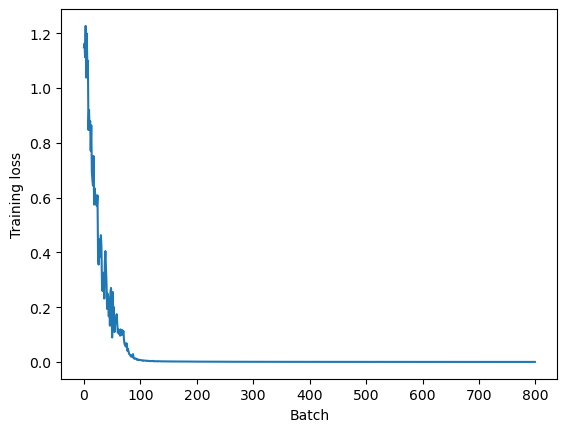

  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 38.24



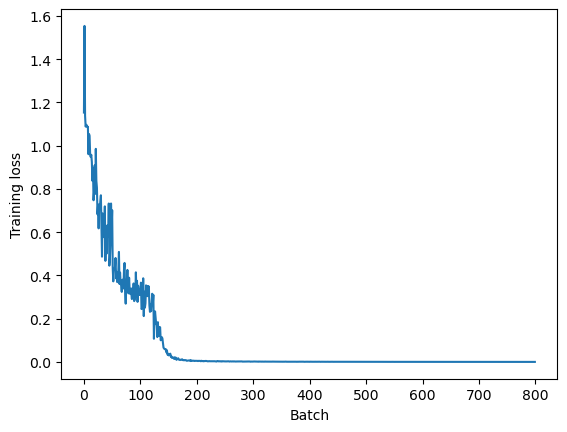

  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 75.00



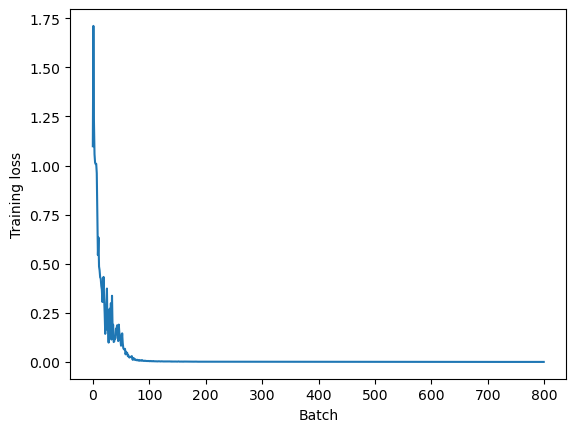

  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 79.41



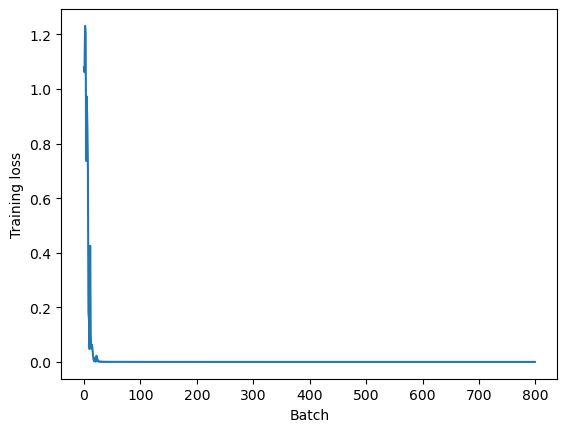

  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 256 training samples: 100.00
Accuracy on the 68 testing samples: 88.24



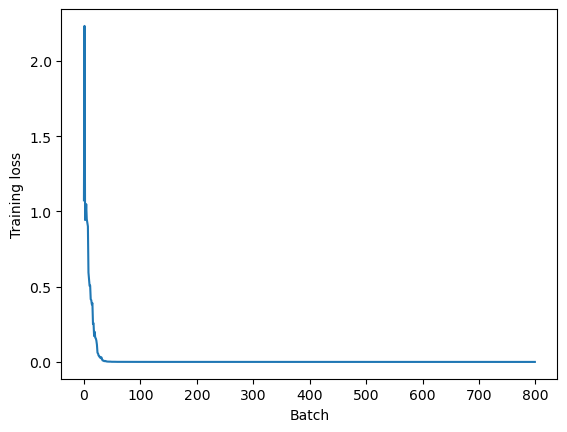

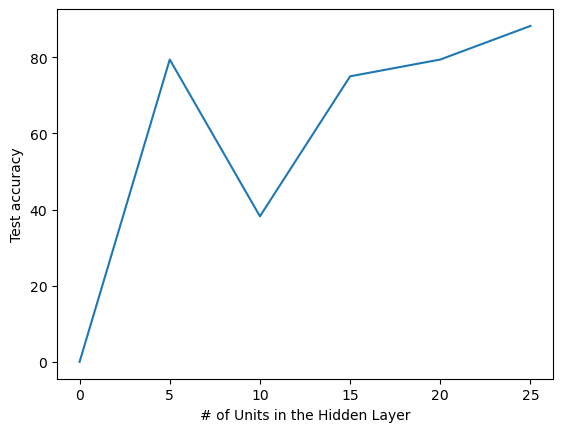

In [17]:

set_seed(seed=SEED)
max_par_count = 100
## Uncomment below to test your function
test_scores =[0]
for hidden_units in [5, 10, 15, 20, 25]:
  wide_net = Net('ReLU()', X_train.shape[0], [hidden_units], 3).to(device)  # single hidden layer
  # hidden_layers, test_scores = run_depth_optimizer(max_par_count, max_hidden_layer, DEVICE)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(wide_net.parameters(), lr=1e-3)
  _, test_acc = train_test_classification(wide_net, criterion, optimizer,
                                              train_loader, test_loader,
                                              num_epochs=100, device=device)
  test_scores += [test_acc]



plt.plot([0,5, 10, 15, 20, 25], test_scores)
plt.xlabel('# of Units in the Hidden Layer')
plt.ylabel('Test accuracy')

plt.show()


In [18]:
#############################################
#############################################
#############################################
# 1: We RNN to predict neural acitivity, and we could not make sense of it; i.e the output is firing rate, and comparision is against spike count; loss does not decay
# 2: We try MLP to predict responses from all neural data: as shown above
# 3: To do:
#         1. Find a way to see the hidden layder weights as shown in W1D5 Tutorial 1 Video 2: Case Study - MLP Classification;
#         2. Whether RNN can perform a better job? MLP needs to flatten the raster plots, so the input parameters is hugh: neurons (698) x timebins (250)
#         3. Instead of using responses as output, can we try out other behavior-related signals(reaction time, pupil size, ...) as output